# Recommendation System 

In this notebook, I am implementing recommendation system using item-based collaborative filtering. I use data from MovieLens, consisting of 20 million ratings applied to 27,000 movies by 138,000 users, which is found at https://grouplens.org/datasets/movielens/. My implementation consists of 4 main parts: data manipulation, algorithm implementation, testing and visualization. 

## Data Manipulation

I download the csv files from the Movielens web page and import them into my local MySQL database. Then I use SQL query to get the subset of data that I need for the project. After getting the subset of data that I need to build the recommend system, I convert it to pandas data frame then preprocess for later use in utility matrix.

In [1]:
import json
import sqlalchemy as sa
import pandas as pd
import requests

def getCreds(filename, subset, defaults = {}):
    """ Use `filename` to look for a file containing a json-encoded dictionary
        of credentials.  If the file is successfully found and contains valid
        json, return the sub-dictionary based on `subset`.  If the file is not
        found, is not accessible, has improper encoding, or if the subset is 
        not present in the dictionary, return the given defaults.
    """
    try:
        with open(filename, 'r') as file:
            D = json.load(file)
            if D[subset]:
                return D[subset]
            else:
                return defaults
    except:
        return defaults

creds = getCreds("creds.json", "mysql", defaults={'user': 'studen_j1', 
                                                  'password': 'studen_j1'})
creds_eventbrite = getCreds("creds.json", "eventbrite")
def db_setup(user, password, database):
    template = 'mysql+mysqlconnector://{}:{}@127.0.0.1:3306/'
    cstring = template.format(user, password, database)
    e = sa.create_engine(cstring)
    c = e.connect()
    return e, c, cstring

In [2]:
 try:
    connection.close()
    del engine
except:
    pass
database = creds['user']
engine, connection, cstring = db_setup(creds['user'], creds['password'], database)


In [3]:
%load_ext sql

In [4]:
%sql $cstring

'Connected: root@'

In [5]:
%sql USE ratings

0 rows affected.


[]

In [6]:
def get_ratings_data(connection,start_users, end_users, n_movies):
    '''
    This function helps us get the subset of users and movies from 
    the SQL database
    '''
    query_template = """
    SELECT *
    FROM ratings.ratings
    WHERE userID >= {} and userID <= {} and movieID <= {}
    """
    query = query_template.format(start_users,end_users,n_movies)
    result_proxy = connection.execute(query)
    query_result = result_proxy.fetchall()
    query_headers = result_proxy.keys()
    df = pd.DataFrame(query_result,columns = query_headers)
    return df

In [7]:
ratings_df = get_ratings_data(connection,1,100,500)

In [8]:
ratings_df

userID  movieID  rating   timestamp
0          1        2     3.5  1112486027
1          1       29     3.5  1112484676
2          1       32     3.5  1112484819
3          1       47     3.5  1112484727
4          1       50     3.5  1112484580
5          1      112     3.5  1094785740
6          1      151     4.0  1094785734
7          1      223     4.0  1112485573
8          1      253     4.0  1112484940
9          1      260     4.0  1112484826
10         1      293     4.0  1112484703
11         1      296     4.0  1112484767
12         1      318     4.0  1112484798
13         1      337     3.5  1094785709
14         1      367     3.5  1112485980
15         2        3     4.0   974820889
16         2       62     5.0   974820598
17         2       70     5.0   974820691
18         2      110     4.0   974820658
19         2      242     3.0   974820776
20         2      260     5.0   974821014
21         2      266     5.0   974820748
22         2      469     3.0   974820598
23         2      480     5.0   974820720
24         3        1     4.0   944919407
25         3       24     3.0   945176048
26         3       32     4.0   944918047
27         3       50     5.0   944918018
28         3      160     3.0   945176048
29         3      173     2.0   945176099
...      ...      ...     ...         ...
2238     100       25     4.0   835720262
2239     100       32     3.0   835719889
2240     100       39     3.0   835719912
2241     100       50     5.0   835719889
2242     100       70     3.0   835720727
2243     100      161     3.0   835719798
2244     100      162     4.0   835720999
2245     100      185     2.0   835719825
2246     100      194     3.0   835720813
2247     100      223     4.0   835720262
2248     100      235     4.0   835720107
2249     100      260     4.0   865874456
2250     100      265     4.0   835720189
2251     100      288     4.0   835719847
2252     100      293     5.0   835720107
2253     100      296     4.0   835719709
2254     100      318     3.0   835719774
2255     100      329     3.0   835719774
2256     100      337     3.0   835719952
2257     100      339     3.0   835719798
2258     100      342     4.0   835720416
2259     100      344     3.0   835719734
2260     100      356     4.0   835719952
2261     100      427     2.0   835720568
2262     100      431     3.0   835720450
2263     100      434     2.0   835719798
2264     100      435     3.0   835719933
2265     100      471     3.0   835720639
2266     100      481     3.0   835721277
2267     100      500     2.0   835720244

[2268 rows x 4 columns]

In [9]:
def preprocess_ratings_data(users,movies,ratings):
    '''
    This function transforms the pandas table into a dictionary
    with userID as keys and movieID and ratings as 
    tuple of values
    '''
    mov_dict = {}
    for i in range(len(users)):
        if users[i] not in mov_dict:
            mov_dict[users[i]] = [(movies[i],ratings[i])]
        else:
            mov_dict[users[i]].append((movies[i],ratings[i]))
    return mov_dict

In [10]:
user_list = ratings_df['userID']
movie_list = ratings_df['movieID']
rating_list = ratings_df['rating']
mov_dict = preprocess_ratings_data(user_list,movie_list,rating_list)

In [11]:
def get_movie_name_data():
    """
    This function get the movies' names from the database
    """
    query = """
    SELECT *
    FROM ratings.movies
    """
    result_proxy = connection.execute(query)
    query_result = result_proxy.fetchall()
    query_headers = result_proxy.keys()
    df = pd.DataFrame(query_result,columns = query_headers)
    return df

In [12]:
movie_df = get_movie_name_data()
movie_df

movieId                                              title  \
0          1                                   Toy Story (1995)   
1          2                                     Jumanji (1995)   
2          3                            Grumpier Old Men (1995)   
3          4                           Waiting to Exhale (1995)   
4          5                 Father of the Bride Part II (1995)   
5          6                                        Heat (1995)   
6          7                                     Sabrina (1995)   
7          8                                Tom and Huck (1995)   
8          9                                Sudden Death (1995)   
9         10                                   GoldenEye (1995)   
10        11                     American President, The (1995)   
11        12                 Dracula: Dead and Loving It (1995)   
12        13                                       Balto (1995)   
13        14                                       Nixon (1995)   
14        15                            Cutthroat Island (1995)   
15        16                                      Casino (1995)   
16        17                       Sense and Sensibility (1995)   
17        18                                  Four Rooms (1995)   
18        19              Ace Ventura: When Nature Calls (1995)   
19        20                                 Money Train (1995)   
20        21                                  Get Shorty (1995)   
21        22                                     Copycat (1995)   
22        23                                   Assassins (1995)   
23        24                                      Powder (1995)   
24        25                           Leaving Las Vegas (1995)   
25        26                                     Othello (1995)   
26        27                                Now and Then (1995)   
27        28                                  Persuasion (1995)   
28        29  City of Lost Children, The (Cit̩ des enfants p...   
29        30  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
..       ...                                                ...   
467      471                        Hudsucker Proxy, The (1994)   
468      472                            I'll Do Anything (1994)   
469      473                             In the Army Now (1994)   
470      474                         In the Line of Fire (1993)   
471      475                   In the Name of the Father (1993)   
472      476                                Inkwell, The (1994)   
473      477              What's Love Got to Do with It? (1993)   
474      478                             Jimmy Hollywood (1994)   
475      479                              Judgment Night (1993)   
476      480                               Jurassic Park (1993)   
477      481                                  Kalifornia (1993)   
478      482                                 Killing Zoe (1994)   
479      483                            King of the Hill (1993)   
480      484                                      Lassie (1994)   
481      485                            Last Action Hero (1993)   
482      486                             Life with Mikey (1993)   
483      487                              Lightning Jack (1994)   
484      488                                M. Butterfly (1993)   
485      489                             Made in America (1993)   
486      490                                      Malice (1993)   
487      491                     Man Without a Face, The (1993)   
488      492                    Manhattan Murder Mystery (1993)   
489      493                           Menace II Society (1993)   
490      494                          Executive Decision (1996)   
491      495  In the Realm of the Senses (Ai no corrida) (1976)   
492      496                        What Happened Was... (1994)   
493      497                      Much Ado About Nothing (1993)   
494      498                                   Mr. J

In [13]:
def preprocess_movies_info_data(movieId_list, title_list, genres_list):
    '''
    This function transforms the pandas table into a dictionary with movieId as key
    to make movie lookup easier
    '''
    movie_info_dict = {}
    for i in range(len(movieId_list)):
        movie_info_dict[movieId_list[i]] = (title_list[i],genres_list[i])
    
    return movie_info_dict

In [14]:
movieId_list = movie_df['movieId']
title_list = movie_df['title']
genres_list = movie_df['genres']
movie_info_dict = preprocess_movies_info_data(movieId_list,title_list,genres_list)
movie_info_dict

{1: ('Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'),
 2: ('Jumanji (1995)', 'Adventure|Children|Fantasy'),
 3: ('Grumpier Old Men (1995)', 'Comedy|Romance'),
 4: ('Waiting to Exhale (1995)', 'Comedy|Drama|Romance'),
 5: ('Father of the Bride Part II (1995)', 'Comedy'),
 6: ('Heat (1995)', 'Action|Crime|Thriller'),
 7: ('Sabrina (1995)', 'Comedy|Romance'),
 8: ('Tom and Huck (1995)', 'Adventure|Children'),
 9: ('Sudden Death (1995)', 'Action'),
 10: ('GoldenEye (1995)', 'Action|Adventure|Thriller'),
 11: ('American President, The (1995)', 'Comedy|Drama|Romance'),
 12: ('Dracula: Dead and Loving It (1995)', 'Comedy|Horror'),
 13: ('Balto (1995)', 'Adventure|Animation|Children'),
 14: ('Nixon (1995)', 'Drama'),
 15: ('Cutthroat Island (1995)', 'Action|Adventure|Romance'),
 16: ('Casino (1995)', 'Crime|Drama'),
 17: ('Sense and Sensibility (1995)', 'Drama|Romance'),
 18: ('Four Rooms (1995)', 'Comedy'),
 19: ('Ace Ventura: When Nature Calls (1995)', 'Comedy'),
 20: ('Mo

In [15]:
def main_process_data(start_users,end_users,n_movies):
    '''
    This is the parent function that calls other function 
    in the data manipulation. This function will be called
    in the model testing and visualization part 
    '''
    ratings_df = get_ratings_data(connection,start_users, end_users, n_movies)
    user_list = ratings_df['userID']
    movie_list = ratings_df['movieID']
    rating_list = ratings_df['rating']
    mov_dict = preprocess_ratings_data(user_list,movie_list,rating_list)
     
    return mov_dict

## Algorithm Implementation

In this part, I implement the item-based collaborative filtering algorithm described in the Ullman book. First, I populate the processed data into ultility matrix. Then I calculate the similarity between every pair of movie items. Once we have the item similarity matrix, my algorithm recommends to users the movies that they did not watch but have high similarity with the movies that they did.

In [16]:
def build_utility_matrix(mov_dict,user_size,movie_size,offset):
    '''
    This function builds utility matrix from the preprocessed dictionary
    the rows represent users and the columns represent movies
    '''
    u_matrix = [[0 for i in range(movie_size)] for j in range(user_size)]
    
    for user in mov_dict:
        for movie in mov_dict[user]:
            u_matrix[user-1-offset][movie[0]-1] = int(movie[1])
    return u_matrix
    

In [17]:
u_matrix = build_utility_matrix(mov_dict,100,500,0)
u_matrix

[[0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [18]:
def calculate_similarity(u_matrix,item_size):
    '''
    This function calculates similarity between two items 
    '''
    item_matrix = [[0 for i in range(item_size)] for j in range(item_size)]
    
    for i in range(item_size):
        for j in range(i,item_size):
            intersection = 0 
            total_i = 0 
            total_j = 0
            #calculate similarity between item i and item j 
            for u in range(len(u_matrix)):
                if u_matrix[u][i]> 0 and u_matrix[u][j]> 0 :
                    intersection+=min(u_matrix[u][i],u_matrix[u][j])
                if u_matrix[u][i]> 0:
                    total_i+=u_matrix[u][i]
                if u_matrix[u][j]> 0: 
                    total_j+=u_matrix[u][j]
            if intersection > 0:
                similarity_i_j = intersection/(total_i+total_j-intersection)
                item_matrix[i][j] = similarity_i_j
                item_matrix[j][i] = similarity_i_j  
    
    return item_matrix

In [19]:
item_matrix = calculate_similarity(u_matrix,500)
item_matrix

[[1.0,
  0.08759124087591241,
  0.1619718309859155,
  0,
  0.07575757575757576,
  0.23417721518987342,
  0.19852941176470587,
  0,
  0.022900763358778626,
  0.20261437908496732,
  0.1393939393939394,
  0.023622047244094488,
  0,
  0.028985507246376812,
  0.03007518796992481,
  0.12422360248447205,
  0.1503267973856209,
  0.078125,
  0.10759493670886076,
  0.03816793893129771,
  0.21019108280254778,
  0.10869565217391304,
  0,
  0.10218978102189781,
  0.15,
  0,
  0,
  0,
  0.050359712230215826,
  0,
  0,
  0.32558139534883723,
  0,
  0.18354430379746836,
  0,
  0.15333333333333332,
  0,
  0,
  0.1317365269461078,
  0,
  0.06060606060606061,
  0,
  0,
  0.05263157894736842,
  0.07971014492753623,
  0,
  0.2524271844660194,
  0.0859375,
  0,
  0.22380952380952382,
  0,
  0.11678832116788321,
  0,
  0,
  0.022727272727272728,
  0,
  0,
  0.025974025974025976,
  0,
  0.028985507246376812,
  0.031496062992125984,
  0.2064516129032258,
  0.023622047244094488,
  0,
  0.015625,
  0,
  0.023622

In [20]:
def recommendation(mov_dict,i_matrix):
    '''
    This function finds and returns the best recommendation for each user based on 
    the item similarity matrix
    '''
    recommendation_dict = {}
    for user in mov_dict:
        rec_list = set()
        watched_list = set()
        for movie in mov_dict[user]:
            watched_list.add(movie[0])
        for movie_item in mov_dict[user]:
            if movie_item[1] >=4.0:
                # only recommend movies similar to the movies that the user like   
                movie_list = i_matrix[movie_item[0]-1]
                for i in range(len(movie_list)):
                    if (i+1,movie_list[i]) not in rec_list and i!= movie_item[0] and movie_list[i] < 1 and i+1 not in watched_list:
                        rec_list.add((i+1,movie_list[i]))
        rec_list = sorted(rec_list, key=lambda x: x[1], reverse=True)
        # check to make sure we recommend all different movies in top 5 
        recommendation_dict[user] = dict()
        top5 = 0 
        current = 0 
        while top5 < 5 and current < len(rec_list):
            if rec_list[current][0] not in recommendation_dict[user]:
                recommendation_dict[user][rec_list[current][0]] = rec_list[current][1]
                top5+=1
            current+=1
    return recommendation_dict

In [21]:
recommendation_dict = recommendation(mov_dict,item_matrix)
recommendation_dict


{1: {165: 0.375,
  292: 0.40384615384615385,
  344: 0.3949579831932773,
  356: 0.4131944444444444,
  500: 0.47863247863247865},
 2: {47: 0.4158415841584158,
  356: 0.4669260700389105,
  377: 0.41847826086956524,
  380: 0.4088669950738916,
  457: 0.41545893719806765},
 3: {150: 0.5037593984962406,
  153: 0.5204081632653061,
  185: 0.5106382978723404,
  296: 0.5247148288973384,
  356: 0.4669260700389105},
 4: {153: 0.47560975609756095,
  161: 0.4854368932038835,
  292: 0.49038461538461536,
  466: 0.4634146341463415,
  500: 0.46774193548387094},
 5: {153: 0.5204081632653061,
  165: 0.5980392156862745,
  185: 0.5106382978723404,
  296: 0.5247148288973384,
  315: 0.5},
 6: {32: 0.32558139534883723,
  95: 0.41304347826086957,
  144: 0.3076923076923077,
  356: 0.3134920634920635,
  479: 0.3333333333333333},
 7: {110: 0.3898305084745763,
  296: 0.4131944444444444,
  380: 0.4088669950738916,
  457: 0.41545893719806765,
  500: 0.4253731343283582},
 8: {50: 0.4669603524229075,
  225: 0.4347826086

In [22]:
def get_movie_title(movie_info_dict,movieId):
    '''
    This function gets movie title given user_id 
    '''
    return movie_info_dict[movieId]

In [23]:
def print_result(user,mov_dict,movie_info_dict,recommendation_dict):
    '''
    This function prints out recommendation result for each user 
    '''
    print("User "+str(user)+" have watched these movies: ")
    movie_template = 'Title: {}. Genres: {}'
    for movie_item in mov_dict[user]:
        movie_title = get_movie_title(movie_info_dict,movie_item[0])
        movie_string = movie_template.format(movie_title[0], movie_title[1])
        print(movie_string)
    print('\n')
    print("Top 5 movies recommended for you: ")
    for movie_item in recommendation_dict[user]:
        movie_title = get_movie_title(movie_info_dict,movie_item)
        movie_string = movie_template.format(movie_title[0], movie_title[1])
        print(movie_string)

In [24]:
print_result(100,mov_dict,movie_info_dict,recommendation_dict)

User 100 have watched these movies: 
Title: Nixon (1995). Genres: Drama
Title: Leaving Las Vegas (1995). Genres: Drama|Romance
Title: Twelve Monkeys (a.k.a. 12 Monkeys) (1995). Genres: Mystery|Sci-Fi|Thriller
Title: Clueless (1995). Genres: Comedy|Romance
Title: Usual Suspects, The (1995). Genres: Crime|Mystery|Thriller
Title: From Dusk Till Dawn (1996). Genres: Action|Comedy|Horror|Thriller
Title: Crimson Tide (1995). Genres: Drama|Thriller|War
Title: Crumb (1994). Genres: Documentary
Title: Net, The (1995). Genres: Action|Crime|Thriller
Title: Smoke (1995). Genres: Comedy|Drama
Title: Clerks (1994). Genres: Comedy
Title: Ed Wood (1994). Genres: Comedy|Drama
Title: Star Wars: Episode IV - A New Hope (1977). Genres: Action|Adventure|Sci-Fi
Title: Like Water for Chocolate (Como agua para chocolate) (1992). Genres: Drama|Fantasy|Romance
Title: Natural Born Killers (1994). Genres: Action|Crime|Thriller
Title: LŠon: The Professional (a.k.a. The Professional) (LŠon) (1994). Genres: Action

In [25]:
def main_build_model(mov_dict,n_users,n_items,offset):
    '''
    This is the parent function for the building model part,
    including building utility matrix and calculating similarity.
    This function will be called in the model testing and 
    visualization part 
    '''
    u_matrix = build_utility_matrix(mov_dict,n_users,n_items,offset)
    i_matrix = calculate_similarity(u_matrix,n_items)
    return u_matrix,i_matrix 

In [26]:
def main_recommendation(user,mov_dict,item_matrix):
    '''
    This is the parent function for computing recommendation 
    and print out the result from the given ulitility and item 
    similartity matrix. This function will be called in the model
    testing and visualization part 
    '''
    rec_dict = recommendation(mov_dict,item_matrix)
    print_result(user,mov_dict,movie_info_dict,rec_dict)
    return rec_dict 

## Testing and validating model

In this part, I try to validate similarity matrix is by checking its accuracy in recommending movies. First, I build a model using 1000 first users and 500 movies. Then, I use that model (similarity item matrix) to recommend movies for the next 1000 users  (user_id 1001 to 2000) and also build a model from that subset of users. Last, I check whether the two model recommend the same movies.

In [27]:
def model(start_users,end_users,n_items):
    mov_dict = main_process_data(start_users,end_users,n_items)
    n_users = end_users - start_users+1
    offset = start_users - 1
    u_matrix, i_matrix = main_build_model(mov_dict,n_users,n_items,offset)
    return mov_dict,i_matrix 

In [28]:
mov_dict1,i_matrix1 = model(1,1000,500)
mov_dict1

{1: [(2, 3.5),
  (29, 3.5),
  (32, 3.5),
  (47, 3.5),
  (50, 3.5),
  (112, 3.5),
  (151, 4.0),
  (223, 4.0),
  (253, 4.0),
  (260, 4.0),
  (293, 4.0),
  (296, 4.0),
  (318, 4.0),
  (337, 3.5),
  (367, 3.5)],
 2: [(3, 4.0),
  (62, 5.0),
  (70, 5.0),
  (110, 4.0),
  (242, 3.0),
  (260, 5.0),
  (266, 5.0),
  (469, 3.0),
  (480, 5.0)],
 3: [(1, 4.0),
  (24, 3.0),
  (32, 4.0),
  (50, 5.0),
  (160, 3.0),
  (173, 2.0),
  (175, 5.0),
  (196, 3.0),
  (223, 5.0),
  (260, 5.0),
  (316, 5.0),
  (318, 5.0),
  (329, 5.0),
  (337, 3.0),
  (440, 3.0),
  (442, 3.0),
  (457, 5.0),
  (480, 5.0),
  (490, 5.0)],
 4: [(6, 3.0),
  (10, 4.0),
  (19, 3.0),
  (32, 1.0),
  (165, 3.0),
  (329, 3.0),
  (350, 4.0),
  (356, 4.0),
  (367, 3.0),
  (368, 4.0),
  (370, 4.0),
  (377, 4.0),
  (380, 3.0),
  (420, 3.0),
  (431, 4.0),
  (440, 3.0),
  (454, 5.0),
  (480, 4.0),
  (489, 4.0)],
 5: [(2, 3.0),
  (11, 5.0),
  (17, 3.0),
  (60, 3.0),
  (62, 5.0),
  (104, 2.0),
  (110, 4.0),
  (140, 2.0),
  (141, 5.0),
  (150, 5.0),

In [29]:
mov_dict2,i_matrix2 = model(1001,2000,500)

In [30]:
rec_dict1 = main_recommendation(2,mov_dict1,i_matrix1)

User 2 have watched these movies: 
Title: Grumpier Old Men (1995). Genres: Comedy|Romance
Title: Mr. Holland's Opus (1995). Genres: Drama
Title: From Dusk Till Dawn (1996). Genres: Action|Comedy|Horror|Thriller
Title: Braveheart (1995). Genres: Action|Drama|War
Title: Farinelli: il castrato (1994). Genres: Drama|Musical
Title: Star Wars: Episode IV - A New Hope (1977). Genres: Action|Adventure|Sci-Fi
Title: Legends of the Fall (1994). Genres: Drama|Romance|War|Western
Title: House of the Spirits, The (1993). Genres: Drama|Romance
Title: Jurassic Park (1993). Genres: Action|Adventure|Sci-Fi|Thriller


Top 5 movies recommended for you: 
Title: Forrest Gump (1994). Genres: Comedy|Drama|Romance|War
Title: Speed (1994). Genres: Action|Romance|Thriller
Title: Fugitive, The (1993). Genres: Thriller
Title: True Lies (1994). Genres: Action|Adventure|Comedy|Romance|Thriller
Title: Apollo 13 (1995). Genres: Adventure|Drama|IMAX


In [31]:
rec_dict1

{1: {110: 0.4036095159967186,
  150: 0.36651003844510893,
  356: 0.4234467455621302,
  457: 0.3625659764514819,
  480: 0.3645549941702293},
 2: {150: 0.4167093798052281,
  356: 0.4888791975577846,
  377: 0.4681712962962963,
  380: 0.43817052512704685,
  457: 0.46621621621621623},
 3: {150: 0.4624439461883408,
  296: 0.46515604959384355,
  356: 0.4888791975577846,
  377: 0.4681712962962963,
  380: 0.46299694189602447},
 4: {150: 0.4167093798052281,
  296: 0.4199928083423229,
  318: 0.4234467455621302,
  457: 0.46621621621621623,
  500: 0.418848167539267},
 5: {50: 0.4085520745131245,
  165: 0.4409937888198758,
  296: 0.4550147492625369,
  349: 0.40667361835245047,
  356: 0.4888791975577846},
 6: {32: 0.3112719751809721,
  95: 0.3360927152317881,
  296: 0.3040614709110867,
  356: 0.3159373745483742,
  480: 0.31664348632359757},
 7: {150: 0.4167093798052281,
  296: 0.4199928083423229,
  318: 0.4234467455621302,
  380: 0.43817052512704685,
  457: 0.46621621621621623},
 8: {32: 0.3679138321

In [32]:
rec_dict2 = main_recommendation(2,mov_dict1,i_matrix2)

User 2 have watched these movies: 
Title: Grumpier Old Men (1995). Genres: Comedy|Romance
Title: Mr. Holland's Opus (1995). Genres: Drama
Title: From Dusk Till Dawn (1996). Genres: Action|Comedy|Horror|Thriller
Title: Braveheart (1995). Genres: Action|Drama|War
Title: Farinelli: il castrato (1994). Genres: Drama|Musical
Title: Star Wars: Episode IV - A New Hope (1977). Genres: Action|Adventure|Sci-Fi
Title: Legends of the Fall (1994). Genres: Drama|Romance|War|Western
Title: House of the Spirits, The (1993). Genres: Drama|Romance
Title: Jurassic Park (1993). Genres: Action|Adventure|Sci-Fi|Thriller


Top 5 movies recommended for you: 
Title: Forrest Gump (1994). Genres: Comedy|Drama|Romance|War
Title: Fugitive, The (1993). Genres: Thriller
Title: Speed (1994). Genres: Action|Romance|Thriller
Title: Apollo 13 (1995). Genres: Adventure|Drama|IMAX
Title: Lion King, The (1994). Genres: Adventure|Animation|Children|Drama|Musical|IMAX


In the code above, I build two similarity item matrices, the first one from the ratings of first 100 users, the second from the next 100 users (101 to 200). From the result above, we see that the results from 2 models are similar, but in different order. In order to generalize the test, I will use Jaccard similarity to test the similarity in two recommendation sets 

In [33]:
def test_similarity(rec_dict1,rec_dict2):
    intersection = 0 
    total = 0
    for user in rec_dict1:
        total = total + len(rec_dict1[user])+len(rec_dict2[user])
        for movie in rec_dict1[user]:
            if movie in rec_dict2[user]:
                intersection+=1 
        
    
    return intersection/(total-intersection)

In [34]:
test_similarity(rec_dict1,rec_dict2)

0.562655189538156

## Visualization 

From the 3 parts above, we have built a "proof-of-concept" model of recommendation system and a method to check accuracy of the model. Since this is the big data challenge, there are two  question comes into my mind:
1. Whether the recommendation system is going to give recommendations with higher similarity between movies if user size get bigger?
2. Whether there is higher similarity between the train and test set if user size gets bigger?

In [35]:
import matplotlib.pyplot as plt
def plot_similarity_movies():
    start_users = 1 
    end_users = 100
    user_sizes = []
    similarities = [] 
    while end_users <= 1000:
        print(end_users)
        mov_dict,i_matrix = model(start_users,end_users,500)
        rec_dict = recommendation(mov_dict,i_matrix)
        user = 1
        while user <= 100:
            if user in rec_dict:
                for movie in rec_dict[user]:
                    user_sizes.append(end_users)
                    similarities.append(rec_dict[user][movie])
            user += 1
        end_users += 100
    #plot 
    plt.scatter(user_sizes,similarities)
    plt.title('Correlation between user size and movie similarity')
    plt.xlabel('User Size')
    plt.ylabel('Movie Similarity')
    plt.show()
    
            
            

100
200
300
400
500
600
700
800
900
1000


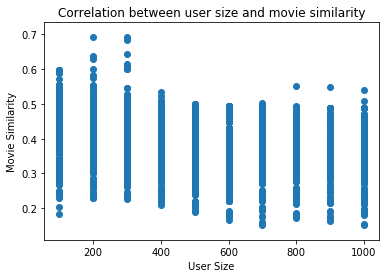

In [36]:
plot_similarity_movies()

In [43]:
def plot_similarity_models():
    size = 100 
    start_users1 = 1
    end_users1 = size 
    start_users2 = end_users1 + 1
    end_users2 = end_users1 + size 
    
    user_size = []
    similarities = [] 
    
    while size <= 2000:
        print(size)
        mov_dict1,i_matrix1 = model(start_users1,end_users1,500)
        rec_dict1 = recommendation(mov_dict1,i_matrix1)
        mov_dict2,i_matrix2 = model(start_users2,end_users2,500)
        rec_dict2 = recommendation(mov_dict1,i_matrix2)
        sim = test_similarity(rec_dict1,rec_dict2)
        user_size.append(size)
        similarities.append(sim)
        size+=100
        end_users1 = size 
        start_users2 = end_users1 + 1
        end_users2 = end_users1 + size 
        
    plt.scatter(user_size,similarities)
    plt.title('Correlation between user size and movie similarity')
    plt.xlabel('User Size')
    plt.ylabel('Model Similarity')
    plt.show()
        
    
        
    
    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


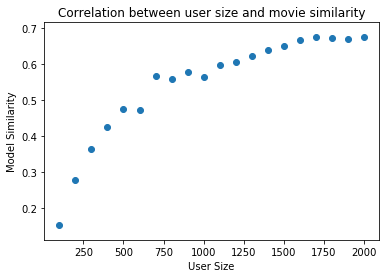

In [44]:
plot_similarity_models()